In [10]:
from sklearn.preprocessing import MinMaxScaler 
from transformer_encoder_decoder_qr_multivariate_model import TransformerEncoderDecoderQRMultiVariateModel

from utils import *

import random 
import os
import sys 


In [11]:
nhead =  4      # number of heads in the multi-head attention models
d_model = 64 #32    # model dimension
d_hid = 128 #64      # dimension of the feedforward network model
nlayers = 2 #4    # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
dropout = 0.1   # dropout rate

input_length  = 4  # Number of data points in src
output_length = 1  # Number of data points in tgt
nfeatures  = 1     #=3 if using woy
batch_size = 16

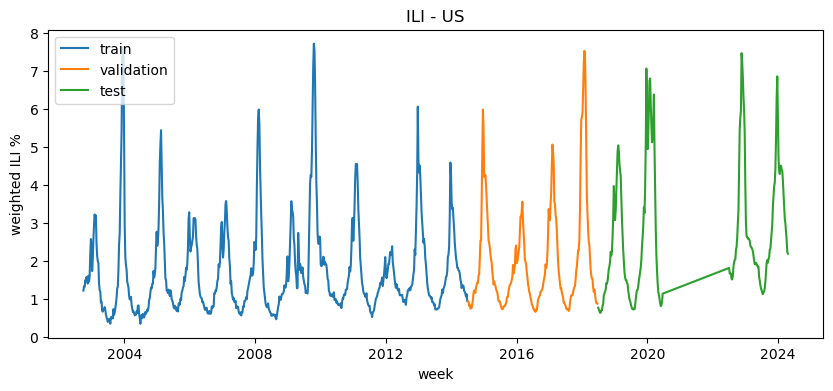

In [12]:
state = 'US'
ILI_df = load_ili_data(state)

start_val_date = pd.Timestamp('2014-07-01') #pd.Timestamp('2016-07-01') #pd.Timestamp('2016-07-01')
start_test_date = pd.Timestamp('2018-07-01') #pd.Timestamp('2019-07-01') #pd.Timestamp('2022-07-01') 

use_validation = True
if(use_validation):
    train_ind = np.where(ILI_df.index<start_val_date)[0] 
    val_ind = np.where((ILI_df.index>=start_val_date) & (ILI_df.index<start_test_date))
else:
    train_ind = np.where(ILI_df.index<start_test_date)[0]
    val_ind = []
# covid_ind = np.where((ILI_df.index>='2020-06-28') & (ILI_df.index<'2022-07-01'))
test_ind = np.where((ILI_df.index>=start_test_date))[0]

plt.figure(figsize=(10,4))
plt.plot(ILI_df.loc[ILI_df.iloc[train_ind].index,'weighted_ili'],label='train') 
if(use_validation):
    plt.plot(ILI_df.loc[ILI_df.iloc[val_ind].index,'weighted_ili'],label='validation') 
# plt.plot(ILI_df.loc[ILI_df.iloc[covid_ind].index,'weighted_ili'],label='throw (covid)') 
plt.plot(ILI_df.loc[ILI_df.iloc[test_ind].index,'weighted_ili'],label='test') 
plt.ylabel('weighted ILI %') 
plt.xlabel('week') 
plt.title('ILI - {}'.format(state)) 
plt.legend(loc=2)
plt.show()

In [13]:
ili = np.expand_dims(ILI_df['weighted_ili'].values,-1)
train_ili = ili[train_ind]
val_ili = ili[val_ind]
test_ili = ili[test_ind]

test_dates = ILI_df.index[test_ind]

scaler = MinMaxScaler() 
scaler.fit(train_ili)
train_data = scaler.transform(train_ili)
if(use_validation):
    val_data = scaler.transform(val_ili)
else:
    val_data = []
test_data = scaler.transform(test_ili)

woy = np.expand_dims(ILI_df['week'].values-1,-1) #0-index based
train_woy = woy[train_ind]
val_woy = woy[val_ind]
test_woy = woy[test_ind]

print(len(train_data))
print(len(val_data))
print(len(test_data))

614
208
199


4
1


c:\Users\ry2460\anaconda3\envs\timeseries_forecasting\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


epoch 0: training loss: 1.4313, validation loss: 0.9742
epoch 1: training loss: 1.1057, validation loss: 0.9536
epoch 2: training loss: 0.9199, validation loss: 0.5981
epoch 3: training loss: 0.7651, validation loss: 0.5682
epoch 4: training loss: 0.6805, validation loss: 0.4621
epoch 5: training loss: 0.5888, validation loss: 0.4311
epoch 6: training loss: 0.5256, validation loss: 0.3413
epoch 7: training loss: 0.4699, validation loss: 0.3281
epoch 8: training loss: 0.4306, validation loss: 0.2622
epoch 9: training loss: 0.3947, validation loss: 0.2495
epoch 10: training loss: 0.3656, validation loss: 0.2816
epoch 11: training loss: 0.3334, validation loss: 0.332
epoch 12: training loss: 0.3467, validation loss: 0.2482
epoch 13: training loss: 0.3175, validation loss: 0.2716
epoch 14: training loss: 0.3107, validation loss: 0.2129
epoch 15: training loss: 0.3134, validation loss: 0.2031
epoch 16: training loss: 0.308, validation loss: 0.3776
epoch 17: training loss: 0.3186, validation

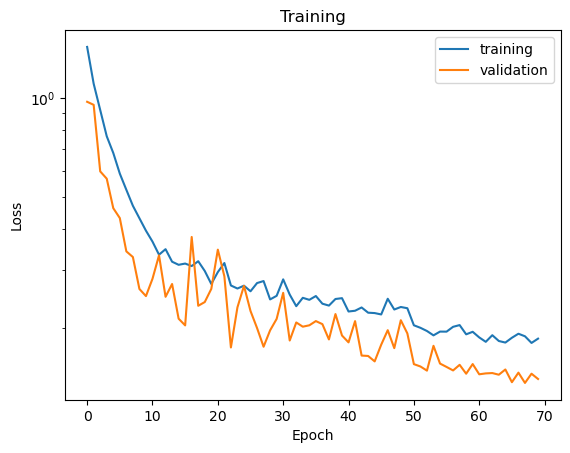

In [14]:
weeks_ahead = 1
training_loader  = get_data_loader(train_data, None, input_length, output_length, 
                                   weeks_ahead, batch_size, train_woy, add_ts_features=True)
input_dim = training_loader.dataset[0][0].shape[1]
output_dim = 1 #training_loader.dataset[0][1].shape[1]
print(input_dim)
print(output_dim)

random.seed(1) 
torch.manual_seed(1)

#initializing the model
model = TransformerEncoderDecoderQRMultiVariateModel(nhead, d_model, d_hid, nlayers, 
                                                     input_length, output_length, 
                                                     input_dim, output_dim,
                                                     nquantiles, dropout)
model = model.to(device)

#training
min_loss = sys.maxsize 
training_loss = [] 
if(use_validation):
    validation_loss = []
    val_loader  = get_data_loader(val_data, None, input_length, output_length, 
                                  weeks_ahead, batch_size, val_woy, add_ts_features=True)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
    (model, optimizer, min_loss, training_loss, validation_loss) = \
        run_training_loop_with_validation(50, optimizer, model, min_loss, 
                                          training_loss, validation_loss, training_loader, val_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
    (model, optimizer, min_loss, training_loss, validation_loss) = \
        run_training_loop_with_validation(10, optimizer, model, min_loss, 
                                          training_loss, validation_loss, training_loader, val_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
    (model, optimizer, min_loss, training_loss, validation_loss) = \
        run_training_loop_with_validation(10, optimizer, model, min_loss, 
                                          training_loss, validation_loss, training_loader, val_loader)
else:
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(50, optimizer, model, min_loss, training_loss, training_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
    (model, optimizer, min_loss, training_loss) = \
        run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)

#training progress
plot_training_progress = True
if(plot_training_progress):
    plt.figure()
    plt.title('Training') 
    plt.yscale('log') 
    plt.plot(training_loss, label = 'training') 
    if(use_validation):
        plt.plot(validation_loss, label = 'validation') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend() 
    plt.show()

In [15]:
print(min_loss)

0.13571452389796967


In [16]:
def get_ili_data_and_pred(pred, ili, dates):
    pred_ili = scaler.inverse_transform(pred)
    #slice ili and test_dates to same dates as pred dates
    ili_slice = ili[(len(ili)-len(pred_ili)):]
    dates_slice = dates[(len(ili)-len(pred_ili)):]
    return (pred_ili,ili_slice,dates_slice)

weeks_ahead=1 (length=194): WIS=0.154, Quantile loss=1.663
weeks_ahead=2 (length=193): WIS=0.285, Quantile loss=3.077
weeks_ahead=3 (length=192): WIS=0.409, Quantile loss=4.425
weeks_ahead=4 (length=191): WIS=0.495, Quantile loss=5.37


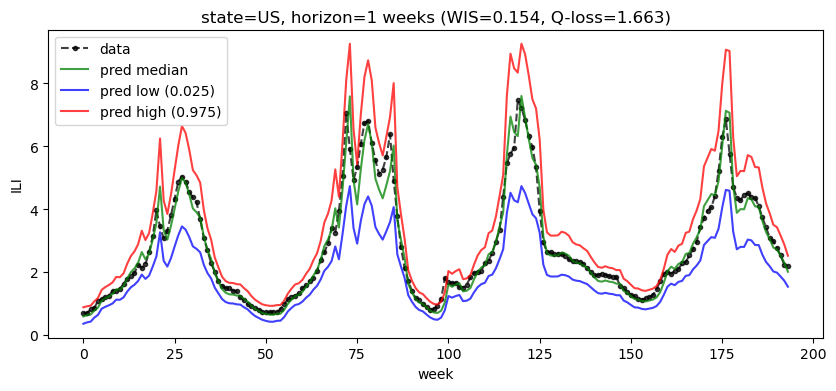

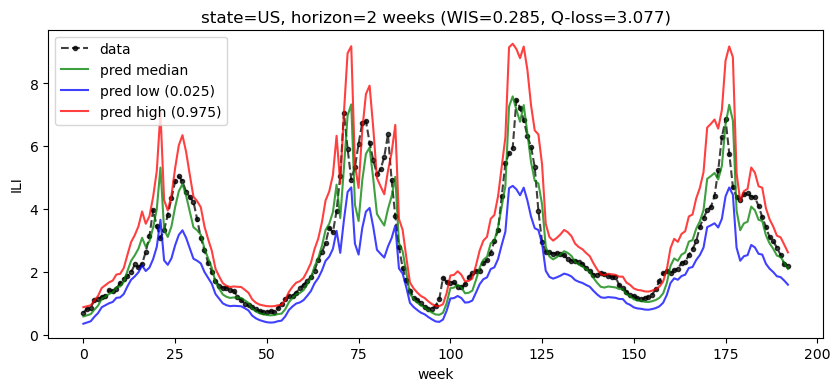

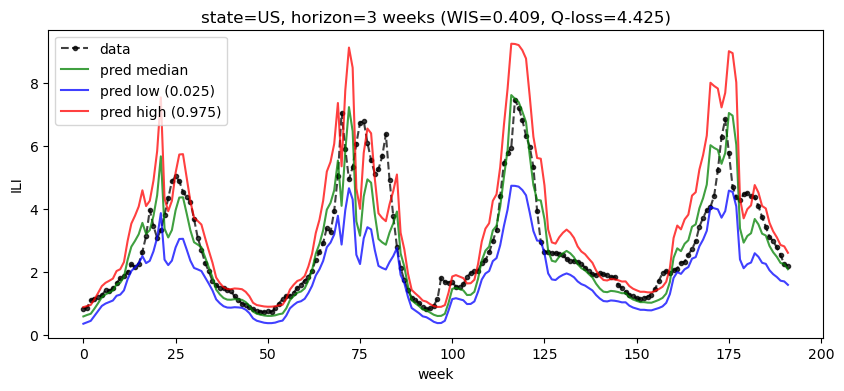

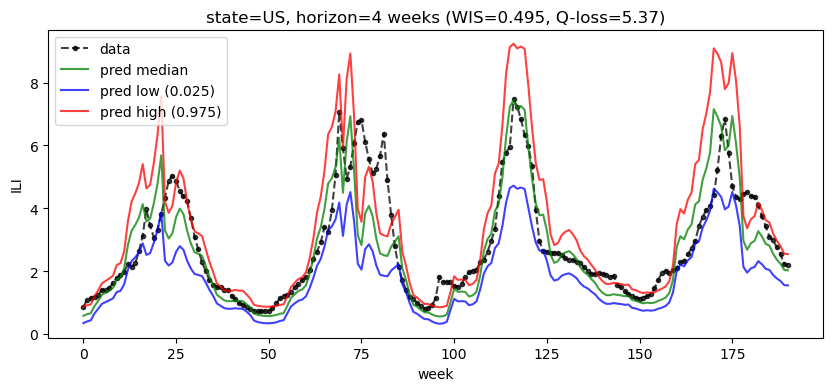

In [17]:
max_horizon = 4
pred_list = None
for i in range(max_horizon):
    weeks_ahead = i+1
    pred_test1 =  get_model_pred(test_data, pred_list, model, weeks_ahead, input_length, output_length, batch_size, test_woy, add_ts_features=True)
    pred_test_ili1, test_ili1, test_dates1 = get_ili_data_and_pred(pred_test1, test_ili, test_dates)
    plot_pred_fit(pred_test_ili1, test_ili1, test_dates1, weeks_ahead, state, use_dates_index=False)
    if(pred_list is None):
        pred_list = [pred_test1]
    else:
        pred_list.append(pred_test1)

In [18]:
# def find_indexes(a, b):
#     return  b.get_indexer(a)

# test_days1 = find_indexes(test_dates1,test_dates)
# test_days2 = find_indexes(test_dates2,test_dates)
# test_days3 = find_indexes(test_dates3,test_dates)
# test_days4 = find_indexes(test_dates4,test_dates)
# test_days5 = find_indexes(test_dates5,test_dates)

# plot_pred_fit(pred_test_ili1, test_ili1, test_days1, weeks_ahead1, state)
# plot_pred_fit(pred_test_ili2, test_ili2, test_days2, weeks_ahead2, state)
# plot_pred_fit(pred_test_ili3, test_ili3, test_days3, weeks_ahead3, state)
# plot_pred_fit(pred_test_ili4, test_ili4, test_days4, weeks_ahead4, state)
# plot_pred_fit(pred_test_ili5, test_ili5, test_days5, weeks_ahead5, state)